In [138]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split

from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import mutual_info_classif
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LogisticRegression

import seaborn as sns

import matplotlib.pyplot as plt
%matplotlib inline

params = {"ytick.color" : "w",
          "xtick.color" : "w",
          "axes.labelcolor" : "w",
          "axes.edgecolor" : "w"}
plt.rcParams.update(params)

Available data details:

| Column            | Definition                            |
| :-                | :-                                    |
|client_id          | client id                             |g
|education          | education level                       |
|sex                | sex                                   |
|age                | age                                   |
|car                | has a car flag                        |
|car_type           | has an foreign car                    |
|decline_app_cnt    | amount of past credit declines        |
|bki_request_cnt    | amount of bank profile requests       |
|home_address       | home address category                 |
|work_address       | work address category                 |
|income             | income                                |
|foreign_passport   | has an international passport flag    |
|default            | had default                           |

In [139]:
data = pd.read_csv('./train.csv')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73799 entries, 0 to 73798
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   client_id         73799 non-null  int64 
 1   education         73492 non-null  object
 2   sex               73799 non-null  object
 3   age               73799 non-null  int64 
 4   car               73799 non-null  object
 5   car_type          73799 non-null  object
 6   decline_app_cnt   73799 non-null  int64 
 7   good_work         73799 non-null  int64 
 8   bki_request_cnt   73799 non-null  int64 
 9   home_address      73799 non-null  int64 
 10  work_address      73799 non-null  int64 
 11  income            73799 non-null  int64 
 12  foreign_passport  73799 non-null  object
 13  default           73799 non-null  int64 
dtypes: int64(9), object(5)
memory usage: 7.9+ MB


In [140]:
data['education'].value_counts(dropna=False)

SCH    38860
GRD    23365
UGR     9816
PGR     1257
NaN      307
ACD      194
Name: education, dtype: int64

<AxesSubplot:>

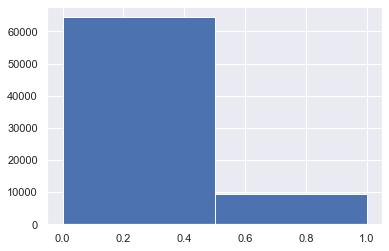

In [141]:
data['default'].hist(bins=2)

On the first glance is appears that we:
1. Have missing values in 'education'. For the time being we are going to fill missing data with the
most common education type, which is SCH.
2. Our target classes are not balanced. We've got way more clients w/o default and that needs to be
taken into consideration later on.

In [142]:
# splitting original dataset into train and validation subsets
train, validation = train_test_split(data, test_size=0.33, random_state=42)

# binary columns
bin_cols = ['sex', 'car', 'car_type', 'good_work', 'foreign_passport']

# category columns
cat_cols = ['education', 'work_address', 'home_address']

# numeric columns
num_cols = ['age', 'decline_app_cnt', 'bki_request_cnt', 'income']

# copying train dataframe to research data structure/dependencies w/o altering the original DF.
train_copy = train[:].copy()

Going to start with numeric data.

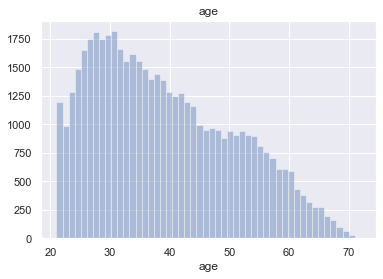

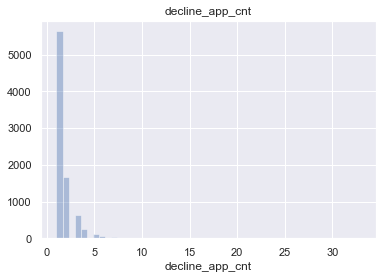

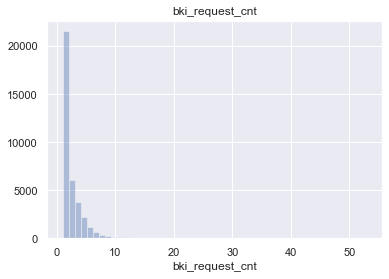

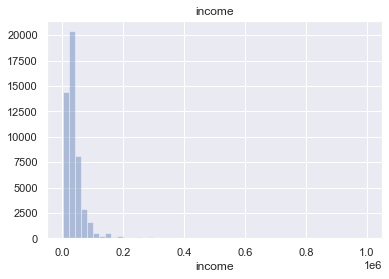

In [143]:
for i in num_cols:
    plt.figure()
    sns.distplot(train_copy[i][train_copy[i] > 0].dropna(), kde = False, rug=False)
    plt.title(i)
    plt.show()

Numeric data distribution isn't normal on any of 4 numeric parameters.
Also "income" has an extremely high range of values (up to 1e6).

I'm going to try applying log() on all numeric parameter values to bring distribution closer to normal.

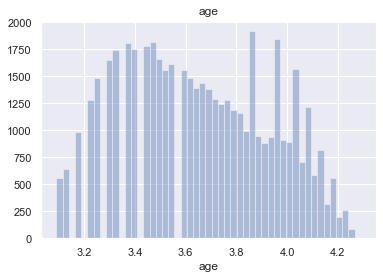

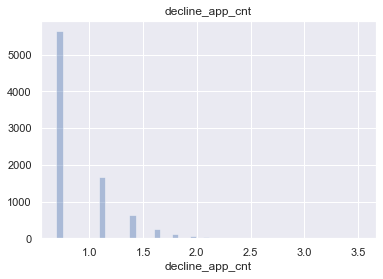

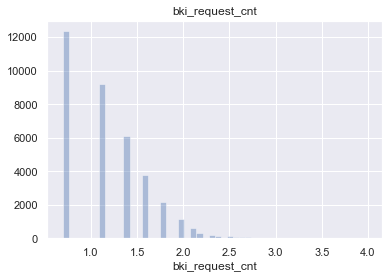

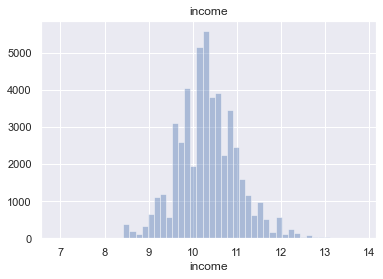

In [144]:
# normalizing numeric data
for column_name in num_cols:
    train_copy[column_name] = train_copy[column_name].apply(lambda x: np.log(x+1))

for i in num_cols:
    plt.figure()
    sns.distplot(train_copy[i][train_copy[i] > 0].dropna(), kde = False, rug=False)
    plt.title(i)
    plt.show()

"income" data distribution looks normal now, "age" also got closer to a normal distribution.

Let's now get more clues on how numeric values relate to our target "default" value.

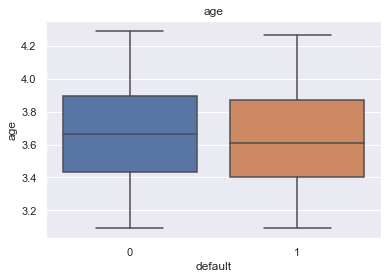

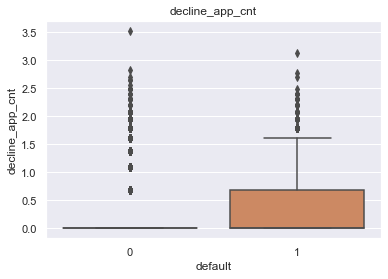

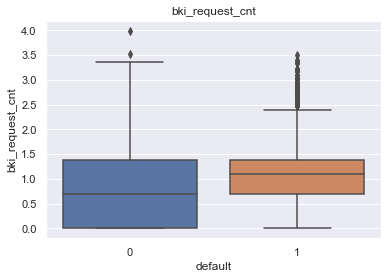

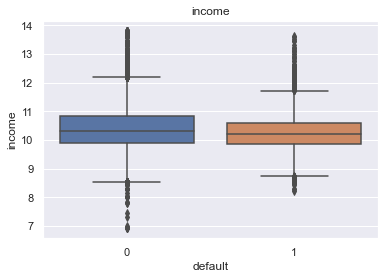

In [145]:
for column_name in num_cols:
    plt.figure()
    sns.boxplot(x=train_copy["default"], y=train_copy[column_name]);
    plt.title(column_name)
    plt.show()

It seems that 'default' clients tend to be:
1. Younger on average.
1. Having higher chances of credit decline, which kind of makes sense.
However these declines are probably result of having 'default' status which makes it irrelevant for default prediction.
Possible data leak.
1. Having more BKI requests on average and having higher chances of having BKI requests at all.
But I have same concerns as for declines here.
1. Having lower income.

Let's now see how numeric parameters correlate to each other and the target value.

<AxesSubplot:>

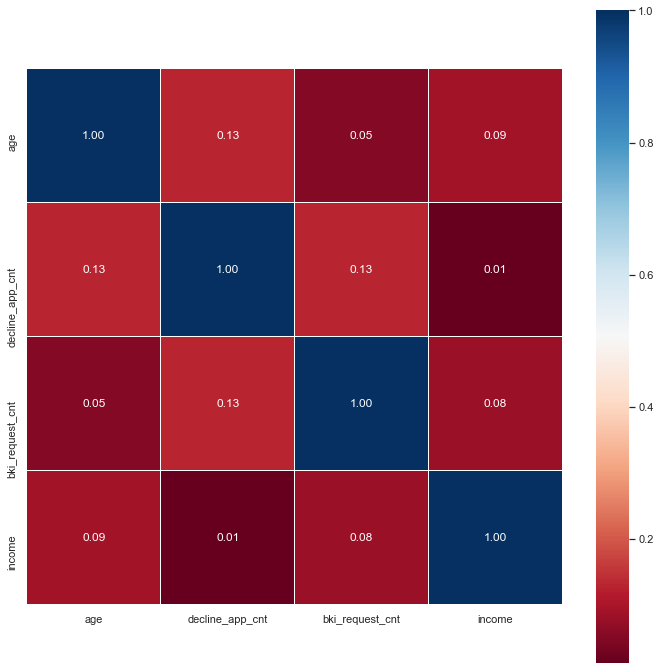

In [146]:
sns.set(font_scale=1)
plt.subplots(figsize=(12, 12))
sns.heatmap(train_copy[num_cols].corr().abs(), square=True,
              annot=True, fmt=".2f", linewidths=0.1, cmap="RdBu")

The highest correlation is .13 between declines and BKI requests. This means we may keep all the numeric parameters.

Let's now see the influence numeric values have on out target value:

<AxesSubplot:>

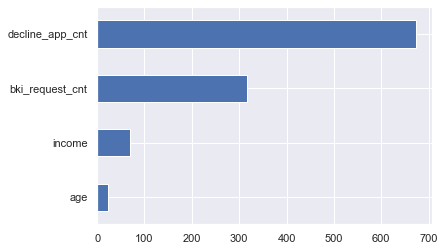

In [147]:
from sklearn.feature_selection import f_classif

imp_num = pd.Series(f_classif(train[num_cols], train['default'])[0], index = num_cols)
imp_num.sort_values(inplace = True)
imp_num.plot(kind = 'barh')

Of all four parameters the decline_app_cnt has he most influence.

Let's now review binary and category parameters. However we must first map these values to integers.

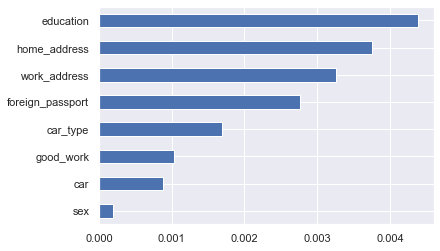

In [148]:
label_encoder = LabelEncoder()

# mapping binary data with integers
for column in bin_cols:
        train_copy[column] = label_encoder.fit_transform(train_copy[column])

# defined mapping of education level to integers
education_index = {
    'SCH': 0,
    'UGR': 1,
    'GRD': 2,
    'PGR': 3,
    'ACD': 4,
}

# mapping the education data
train_copy.education = train_copy.education.apply(lambda x: education_index.get(x, 0))

# plotting the influence level of all the binary/category parameters to the target value
imp_cat = pd.Series(mutual_info_classif(train_copy[bin_cols + cat_cols], train_copy['default'],
                                     discrete_features =True), index = bin_cols + cat_cols)
imp_cat.sort_values(inplace = True)
imp_cat.plot(kind = 'barh');

Education seem to have the most influence followed by home and work addresses.

Now it's time to prepare train data the similar way we did it for research and see what results we are
going get with Logistic Regression before making any further changes.

In [153]:
num_cols.remove('decline_app_cnt')

def pre_process(df, scaler):

    print(pd.DataFrame(np.hstack([df[num_cols].values, df[bin_cols].values, df[cat_cols].values])).head())

    # scaling numeric values
    X_num = scaler.transform(df[num_cols].values)

    # mapping binary data to integers
    encoder = LabelEncoder()

    for column in bin_cols:
        df[column] = encoder.fit_transform(df[column])

    # mapping category data to integers (we had on education left to map)
    df.education = df.education.apply(lambda x: education_index.get(x, 0))

    # adding dummy variables for cat values
    X_cat = OneHotEncoder(sparse = False).fit_transform(df[cat_cols].values)

    print(pd.DataFrame(np.hstack([X_num, df[bin_cols].values, X_cat])).head())

    # combine processed properties together for the X output while also separating the target value to Y
    return np.hstack([X_num, df[bin_cols].values, X_cat]), df['default'].values

scaler = StandardScaler()
scaler.fit(train[num_cols])

X_train, y_train = pre_process(train, scaler)
X_validation, y_true = pre_process(validation, scaler)

pd.DataFrame(y_true).head()

    0  1      2  3  4  5  6  7  8  9  10
0  27  3  30000  0  0  0  0  0  2  3   2
1  47  4  20000  0  0  0  0  0  2  2   1
2  47  0  45000  0  0  0  0  0  0  3   2
3  32  3  21000  0  0  0  0  0  0  3   2
4  31  6  30000  0  0  0  1  1  0  3   2
          0         1         2    3    4    5    6    7    8    9   10   11  \
0 -1.069945  0.443987 -0.239916  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  1.0   
1  0.669278  0.888990 -0.457938  0.0  0.0  0.0  0.0  0.0  1.0  0.0  1.0  0.0   
2  0.669278 -0.891024  0.087117  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  1.0   
3 -0.635139  0.443987 -0.436136  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  1.0   
4 -0.722100  1.778997 -0.239916  0.0  0.0  0.0  1.0  1.0  1.0  0.0  0.0  1.0   

    12   13   14  
0  0.0  1.0  0.0  
1  1.0  0.0  0.0  
2  0.0  1.0  0.0  
3  0.0  1.0  0.0  
4  0.0  1.0  0.0  
    0  1      2  3  4  5  6  7  8  9  10
0  29  3  23000  0  0  0  0  0  1  2   1
1  58  2  15000  1  0  0  0  0  0  2   1
2  69  0  23500  0  0  0  0  0  2  3

<ipython-input-153-cf901ed4a5a9>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column] = encoder.fit_transform(df[column])
C:\Users\Kirill\anaconda3\envs\skillfactory\lib\site-packages\pandas\core\generic.py:5159: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
<ipython-input-153-cf901ed4a5a9>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: ht

,0
0,0
1,0
2,1
3,0
4,1


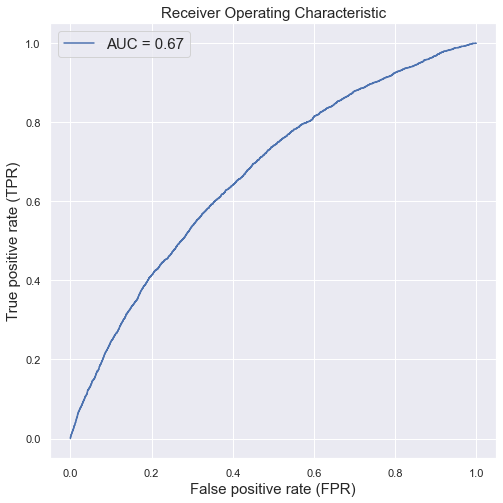

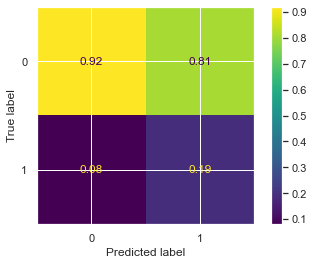

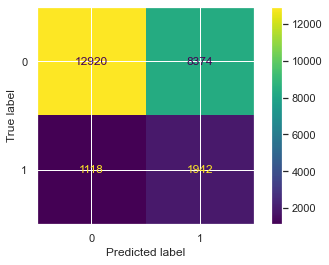

[[12920  8374]
 [ 1118  1942]]


In [152]:
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, plot_confusion_matrix, confusion_matrix

def calc_and_plot_roc(y_true, y_pred_proba):
    # Посчитать значения ROC кривой и значение площади под кривой AUC
    fpr, tpr, thresholds = roc_curve(y_true, y_pred_proba)
    roc_auc = roc_auc_score(y_true, y_pred_proba)

    plt.figure(figsize=(8, 8))
    plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.2f}')
    plt.title('Receiver Operating Characteristic', fontsize=15)
    plt.xlabel('False positive rate (FPR)', fontsize=15)
    plt.ylabel('True positive rate (TPR)', fontsize=15)
    plt.legend(fontsize=15)

model = LogisticRegression(class_weight='balanced')
model.fit(X_train, y_train)

у_pred_proba = model.predict_proba(X_validation)
y_pred = model.predict(X_validation)

calc_and_plot_roc(y_true, у_pred_proba[:, 1])

plot_confusion_matrix(model, X_validation, y_true, normalize='pred')
plot_confusion_matrix(model, X_validation, y_true)
plt.show();

print(confusion_matrix(y_true, y_pred))

In [151]:
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.92      0.61      0.73     21294
           1       0.19      0.63      0.29      3060

    accuracy                           0.61     24354
   macro avg       0.55      0.62      0.51     24354
weighted avg       0.83      0.61      0.68     24354

